Author: Arend-Jan Quist\
Date of creation: 20 May 2020\
Last modified: 15 June 2020

Create a artificially created dataset of a moire lattice with Gaussian peaks.\
Apply drizzle and shift-and-add to this dataset. \
Apply various types of data processing to these images.

In [1]:
import numpy as np
from scipy import ndimage
from skimage import data, io, filters
import matplotlib.pyplot as plt

from Drizzle import *

#Define folder to save images
save_folder = r"C:\Users\Arend-Jan\Documents\Universiteit\Bachelor Research Project\Thesis\Images_n_gr_1"

Positions of the peaks are defined by parameters h and d.

O===========O===========O======  ---
 X         X X         X X        |
  X       X   X       X   X       |
   X     X     X     X     X      h
    X   X       X   X       X     |
     X X         X X         X    |
======O===========O===========O  ---
     X X         X X         X
    X   X       X   X       X
    
      |-----d-----|
    
O are the peaks


In [2]:
def create_gaussian(sigma,size,pos):
    """Create a gaussian with standarddeviation sigma at an array of size with peak
    at a given position.
    """
    x, y = np.meshgrid(np.arange(0,size[0]) - pos[0], np.arange(0,size[1]) - pos[1])
    
    d = np.sqrt(x*x+y*y)
    g = np.exp(-( (d)**2 / ( 2.0 * sigma**2 ) ) )
    #plt.imshow(g)
    #plt.show()
    return (g.T)

def create_lattice_images(mean_shifts=0,sigma_shifts = 1.,shift_bias=0,seed_input=2020,size = [40,40],n_input=50,
                         sigma = 5.,d=10,h=None):
    """
    Create artificial dataset of shifted images of Gaussian bulbs on a lattice.
    
    Parameters:
    "sigma_shifts" is the standard deviation of the shifts of the images.
    "shift_bias" is the standard deviation of the bias added to the shifts.
    "seed_input" is the seed used for dataset creation.
    "size" is image size.
    "n_input" is number of input images.
    "sigma" is the width of the bulbs in the images.
    "d" and "h" are geometrical parameters for the lattice, see sketch above.
    """
    
    np.random.seed(seed_input) #set seed
    
    if h == None: 
        h = d*np.sqrt(3)/2 #create triangular lattice
        
    # Create shifts of input images
    shifts = np.random.normal(mean_shifts,sigma_shifts,[n_input,2])

    # Define point of lattice
    lattice_points = []
    brd = np.ceil(4*sigma/h)*h
    for x in np.arange(-brd, size[0] + d + brd, d):
        for y in np.arange(-brd, size[1] + 2*h + brd, 2*h):
            lattice_points.append(np.array([x,y]))
            lattice_points.append(np.array([x+d/2,y+h]))
    
    # Create input images
    ims = []
    for i,shift in enumerate(shifts):
        shift += np.random.normal(0,shift_bias,2)
        im = np.zeros(size)
        for lp in lattice_points:
            im += create_gaussian(sigma,size,lp+shift)
        ims.append(im*10000)
    return (ims,shifts)

def add_noise(ims,shifts,sigm_shift = .1,seed_input=2020):
    """Add noise to given input images and shifts
    
    "sigma_shift" is sigma to bias the shifts.
    "seed_input" is the seed used for noise creation.
    """
    np.random.seed(seed_input) #set seed
    
    sigm_noi_before_blur = 20. #sigma for gaussian noise
    sigm_blur = 0.5 #sigma for gaussian blurring
    sigm_noi_after_blur = 20. #sigma for gaussian noise

    # Add noise to the images
    noise_ims = []
    for im in ims:
        noise_im = im + np.random.normal(0,sigm_noi_after_blur,np.shape(im))
        noise_im = ndimage.filters.gaussian_filter(noise_im,sigm_blur)
        noise_im += np.random.normal(0,sigm_noi_after_blur,np.shape(im))
        noise_ims.append(noise_im)
        
    
    #Add noise to the shifts
    shifts_bias = shifts + np.random.normal(0,sigm_shift,np.shape(shifts))
    
    return(noise_ims,shifts_bias)

def meansh(x):
    """Calculate the mean of shifts modulo 1"""
    av_shift = [np.angle(np.mean(np.exp(1j*2*np.pi*x[:,0])))/2/np.pi%1,np.angle(np.mean(np.exp(1j*2*np.pi*x[:,1])))/2/np.pi%1]
    av_shift = np.round(av_shift,2)
    return(av_shift)

def center_shifts(shift):
    av_shift = meansh(shift)

    shift[:,0] = shift[:,0]+1-av_shift[0]
    shift[:,1] = shift[:,1]+1-av_shift[1]
    return(shift)

# Artificial datasets with various types of shift noise

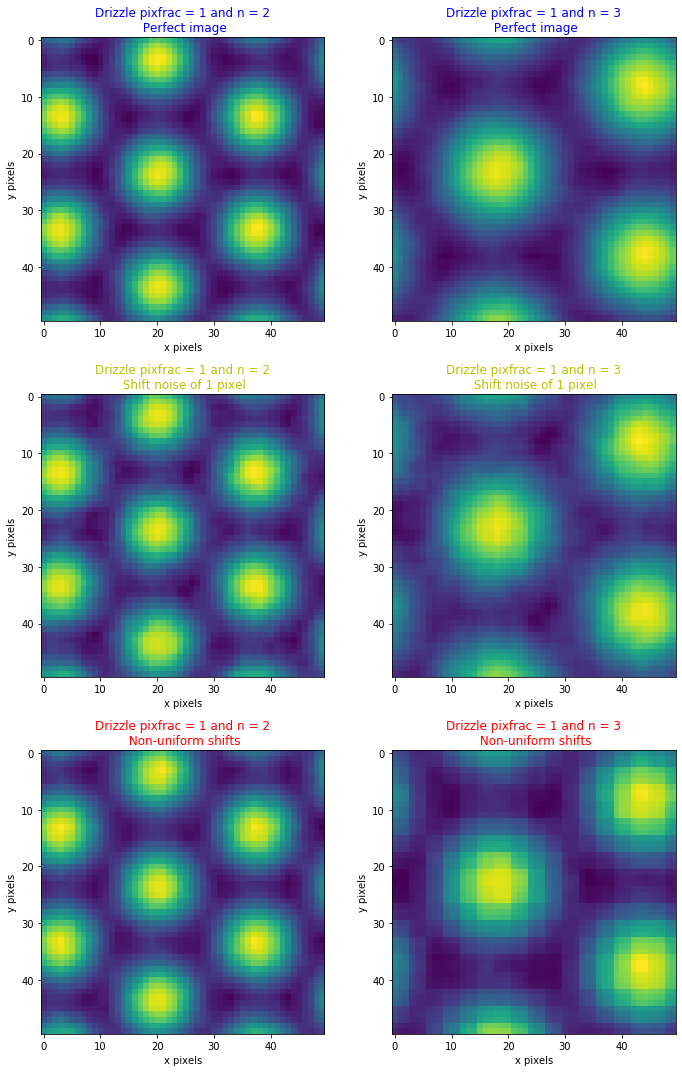

C:\Users\Arend-Jan\anaconda3\lib\site-packages\ipykernel_launcher.py:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


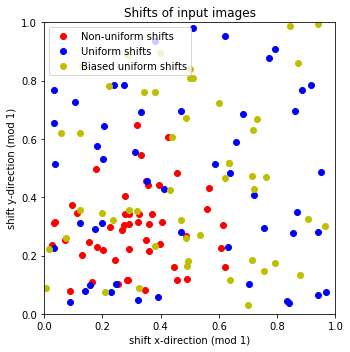

In [3]:
#Plot artificially created images without and with noise in shifts.
p = 1 #pixfrac
n_s = [2,3] #s=1/n scale factors

fig,axs = plt.subplots(3,2,figsize=[10,15])

for i,n in enumerate(n_s):
    ims_orig,shifts_orig = create_lattice_images(0.,1)
    ims,shifts = add_noise(ims_orig,shifts_orig,0.)
    drizzle_im = drizzle(ims,shifts,p,n)

    bord = (len(drizzle_im)-50)//2 #border
    drizzled = drizzle_im[bord:-bord,bord:-bord]

    im=axs[0][i].imshow(drizzled,interpolation='none')
    #plt.colorbar(im,ax=axs[0][0])
    axs[0][i].set_title("Drizzle pixfrac = "+str(p)+" and n = "+str(n)+"\n Perfect image", color="blue")
    axs[0][i].set_xlabel("x pixels")
    axs[0][i].set_ylabel("y pixels")

shift_mod = shifts%1
UNIFORM_SHIFTS = shift_mod

for i,n in enumerate(n_s):
    sigma_shift = 1
    ims_orig,shifts_orig = create_lattice_images(0.,1)
    ims,shifts = add_noise(ims_orig,shifts_orig,sigma_shift)
    drizzle_im = drizzle(ims,shifts,p,n)

    bord = (len(drizzle_im)-50)//2 #border
    drizzled = drizzle_im[bord:-bord,bord:-bord]

    im=axs[1][i].imshow(drizzled,interpolation='none')
    #plt.colorbar(im,ax=axs[1][i])
    axs[1][i].set_title("Drizzle pixfrac = "+str(p)+" and n = "+str(n)+"\n Shift noise of "+str(sigma_shift)+" pixel", color="y")
    axs[1][i].set_xlabel("x pixels")
    axs[1][i].set_ylabel("y pixels")
    
    if n==2: #save image to plot afterwards
        drizzled_SAVE = drizzled
    
shift_mod = shifts%1
BIASED_UNIF_SHIFTS = shift_mod

for i,n in enumerate(n_s):
    ims_orig,shifts_orig = create_lattice_images(0.3,0.15)
    ims,shifts = add_noise(ims_orig,shifts_orig,0)
    drizzle_im = drizzle(ims,shifts,p,n)

    bord = (len(drizzle_im)-50)//2 #border
    drizzled = drizzle_im[bord:-bord,bord:-bord]

    im=axs[2][i].imshow(drizzled,interpolation='none')
    #plt.colorbar(im,ax=axs[2][i])
    axs[2][i].set_title("Drizzle pixfrac = "+str(p)+" and n = "+str(n)+"\n Non-uniform shifts", color="red")
    axs[2][i].set_xlabel("x pixels")
    axs[2][i].set_ylabel("y pixels")

fig.tight_layout()
#plt.savefig(save_folder+'/Artificial_datasets_p='+str(p)+'.pdf', interpolation='none')
plt.show()


plt.rcParams["figure.figsize"] = [5., 5.]

shift_mod = shifts%1
plt.plot(shift_mod[:,0],shift_mod[:,1],"ro",label="Non-uniform shifts")

shift_mod = UNIFORM_SHIFTS
plt.plot(shift_mod[:,0],shift_mod[:,1],"bo",label="Uniform shifts")

shift_mod = BIASED_UNIF_SHIFTS
plt.plot(shift_mod[:,0],shift_mod[:,1],"yo",label="Biased uniform shifts")


plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("shift x-direction (mod 1)")
plt.ylabel("shift y-direction (mod 1)")
plt.title("Shifts of input images")
plt.legend()
plt.axes().set_aspect('equal')

plt.tight_layout()
#plt.savefig(save_folder+'/Artificial_datasets_(un)biased_shifts.pdf')

plt.show()

### Plot image with shift noise of 2 pixels

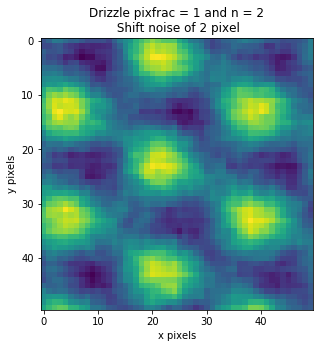

In [6]:
p = 1
n = 2

sigma_shift = 2
ims_orig,shifts_orig = create_lattice_images(0.,1)
ims,shifts = add_noise(ims_orig,shifts_orig,sigma_shift)
drizzle_im = drizzle(ims,shifts,p,n)

bord = (len(drizzle_im)-50)//2 #border
drizzled = drizzle_im[bord:-bord,bord:-bord]

plt.figure(figsize=(5, 5))
plt.imshow(drizzled,interpolation="none")
plt.title("Drizzle pixfrac = "+str(p)+" and n = "+str(n)+"\n Shift noise of "+str(sigma_shift)+" pixel")
plt.xlabel("x pixels")
plt.ylabel("y pixels")
#plt.savefig(save_folder+'/Artificial_datasets_shift_noise2.pdf', interpolation='none')
plt.show()

# Artificial datasets with shift detection algorithm

In [ ]:
#Create and save images

ims_orig,shifts_orig = create_lattice_images(0.0,1,size=[200,200],n_input=100)
ims,shifts = add_noise(ims_orig,shifts_orig,0.0)

np.save('drizzle_ims.npy', ims)
np.save('shifts.npy', shifts_orig)

Apply the shift detection algorithm (see Shift_detection_for_artificial_datasets.ipynb) to the images of drizzle_ims.npy. Save the detected shifts as calculated_shifts.npy.

In [ ]:
#Import shifts calculated by the algorithm
sh = np.load('calculated_shifts.npy')

In [ ]:
# Plot images for calculated shifts

n_s = [2,3]
p_s = [0.1,0.7,1]

fig,axs = plt.subplots(len(p_s),len(n_s),figsize=[len(n_s)*5,len(p_s)*5])

for j,n in enumerate(n_s):
    for i,p in enumerate(p_s):
        drizzled_im = drizzle(ims,-sh,n=n,p=p)
        bord = n*10 #width of images divided by 2
        axs[i][j].imshow(drizzled_im[100*n-bord:-(100*n-bord),100*n-bord:-(100*n-bord)],interpolation="none")
        axs[i][j].set_title("Drizzle pixfrac = "+str(p)+" and n = "+str(n))
        axs[i][j].set_xlabel("x pixels")
        axs[i][j].set_ylabel("y pixels")
        
fig.tight_layout()
#plt.savefig(save_folder+'/Artificial_datasets_calculated_shifts.pdf', interpolation='none')
plt.show()

# Make simulation as a function of number of input images

In [8]:
sigma_shift = 1

ims_orig,shifts_orig = create_lattice_images(0.0,1,size=[40,40],n_input=2000)
ims,shifts = add_noise(ims_orig,shifts_orig,sigma_shift)

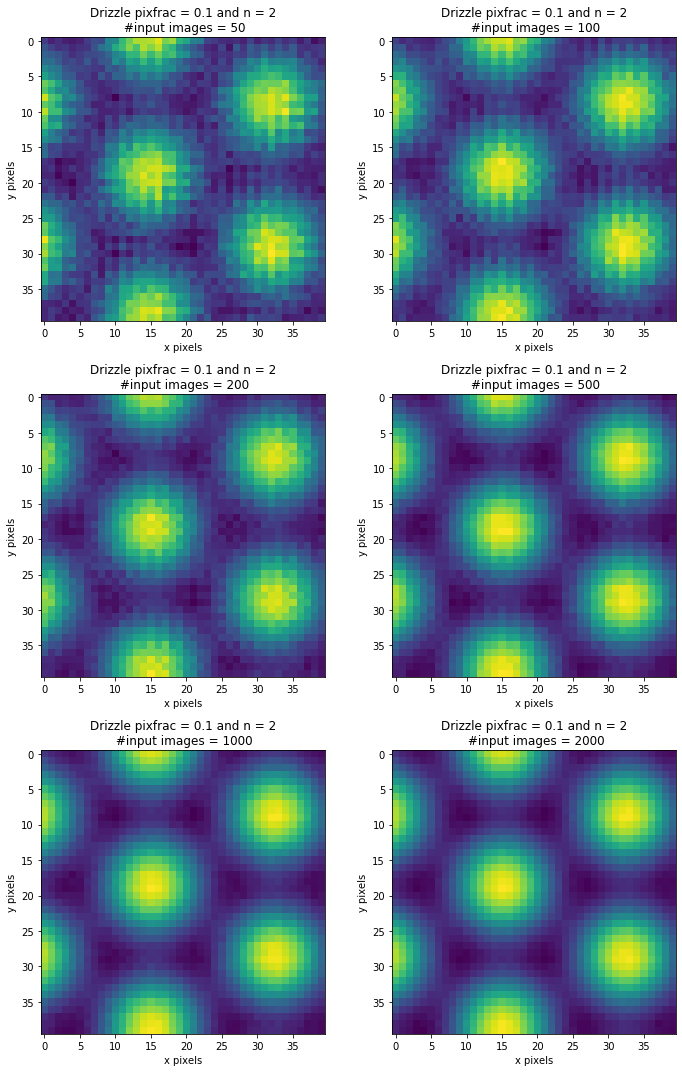

In [9]:
n = 2 #scale factor 1/n
p = 0.1 #pixfrac

n_inputs = [50,100,200,500,1000,2000] #number of input images to plot

fig,axs = plt.subplots(3,2,figsize=[10,15])
axs = axs.flatten()


for i,n_input in enumerate(n_inputs):
    drizzled_im = drizzle(ims[:n_input],shifts[:n_input],p,n)
    bord = 60
    im=axs[i].imshow(drizzled_im[40*n-bord:-(40*n-bord),40*n-bord:-(40*n-bord)],interpolation="none")
    axs[i].set_title("Drizzle pixfrac = "+str(p)+" and n = "+str(n)+ "\n #input images = "+str(n_input))
    axs[i].set_xlabel("x pixels")
    axs[i].set_ylabel("y pixels")
    
fig.tight_layout()
#plt.savefig(save_folder+'/Artificial_datasets_multiple_n_input.pdf', interpolation='none')
plt.show()